# Element Parameter Detection

## Setup

In [1]:
import numpy as np
import math
import random
import os
import os.path
import torch
import sys
import copy
import pickle
import importlib
import torch.nn as nn
import time
import functorch

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from chamferdist import ChamferDistance
from pathlib import Path

import ifcopenshell
import open3d as o3d

from src.elements import *
from src.ifc import *
from src. preparation import *
from src.dataset import *
from src.pointnet import *
from src.visualisation import *
from src.geometry import sq_distance
from src.icp import icp_finetuning
from src.chamfer import *
from src.utils import *
from src.plots import plot_error_graph, plot_parameter_errors
from src.pca import testset_PCA
from src.finetune import chamfer_fine_tune
from tqdm.notebook import tqdm


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
random.seed = 42

In [3]:
#path = Path("ModelNet10")
#path = Path('/content/drive/MyDrive/ElementNet/')
path = Path('output/')
#savepath = '/content/drive/MyDrive/ElementNet/'
savepath = 'models/'

## Model

## Test

Analyze results statistically

POINTNET++

In [4]:
train_transforms = transforms.Compose([
                    Normalize(),
#                    RandomNoise(),
                    ToTensor()
                    ])

In [5]:
# load data and model
BASE_DIR = os.path.dirname(os.path.abspath('industrial-facility-relationships/'))
BASE_DIR = os.path.join(BASE_DIR, 'pointnet2')
ROOT_DIR = BASE_DIR
sys.path.append(os.path.join(ROOT_DIR, 'models'))
inference = True
if inference:
    path = Path('output/bp_data/')
    ext = ".ply"
#     path = Path('tee_fix/')
#     ext = ".pcd"
else:
    path = Path('output2/')
    ext = ".pcd"

cat= 'tee'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_normals = False
cat_targets = {"elbow":14, "tee":19, "pipe":11}

if inference:
    test_ds = PointCloudData(path, valid=True, folder='test', category=cat, transform=train_transforms, inference=True)
    targets = cat_targets[cat]
else:
    test_ds = PointCloudData(path, valid=True, folder='test', category=cat, transform=train_transforms)
    targets = test_ds.targets

testDataLoader = torch.utils.data.DataLoader(dataset=test_ds, batch_size=32)
test_criterion = nn.MSELoss()

model_name = "pointnet2_cls_ssg"
model_path = Path("pointnet2/log/classification/pointnet2_cls_ssg/")
model = importlib.import_module(model_name)


predictor = model.get_model(targets, normal_channel=use_normals)
if device != "cpu":
    predictor = predictor.cuda()

checkpoint = torch.load(model_path/'checkpoints/best_model.pth')
#checkpoint = torch.load(model_path'/checkpoints/models/best_model_t_chamfer_0005_bp.pth')
predictor.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [6]:
blueprint = 'data/sample.ifc'
temp_dir = "output/temp/"
target_dir = "output/tee/test/"

ifcConvert_executable = "scripts/./IfcConvert"
cloudCompare_executable = "cloudcompare.CloudCompare"
sample_size = 2048
threshold = 2

In [7]:
batch_visualise(model_path, blueprint, path, ext, device, ifc=False)

pipe 8954


In [8]:
def model_inference(model, loader, device, calculate_score=False):
    predictor = model.eval()
    predictions_list, pcd_list, id_list = [], [], []
    with torch.no_grad():
        for j, data  in tqdm(enumerate(loader), total=len(loader)):
            points, ids = data['pointcloud'].to(device).float(), data['id'].to(device)
            points = points.transpose(2, 1)
            preds, _ = predictor(points)
            preds, points, ids = preds.to(torch.device('cpu')), points.to(torch.device('cpu')), data['id'].to(torch.device('cpu'))
            for i, pr in enumerate(preds):
                predictions_list.append(pr.numpy())
                pcd_list.append(points[i].numpy())
                id_list.append(ids[i].numpy())

        return (predictions_list, pcd_list, id_list)

In [9]:
if inference:
    predictions_list, cloud_list, id_list = model_inference(predictor.eval(), testDataLoader, device)

  0%|          | 0/28 [00:00<?, ?it/s]

In [13]:
print(np.max(np.hstack(id_list)))

872


In [51]:
def test(model, loader, device, criterion):
    losses = []
    predictor = model.eval()
    cloud_list = []
    label_list = []
    output_list = []
    predictions_list = []
    inputs_list = []
    id_list = []
    parameter_id = 0
    tot = 0
    count = 0
    
    for j, data  in tqdm(enumerate(loader), total=len(loader)):
        inputs, labels, ids = data['pointcloud'].to(device).float(), data['properties'].to(device), data['id'].to(device)
        points, target, ids = data['pointcloud'].to(device).float(), data['properties'].to(device), data['id'].to(device)
        points = points.transpose(2, 1)
        outputs, _ = predictor(points)
        outputs = outputs.to(torch.device('cpu'))
        inputs = points.to(torch.device('cpu'))
        labels = target.to(torch.device('cpu'))
        ids = ids.to(torch.device('cpu'))
        #print(data['pointcloud'].size(), labels.size(), outputs.size())

        for i in range(outputs.size(0)):
            label_list.append(labels[i][parameter_id].item())
            id_list.append(ids[i].item())
            output_list.append(outputs[i][parameter_id].item())
            predictions_list.append(outputs[i].numpy())
            inputs_list.append(labels[i].numpy())
            cloud_list.append(inputs[i].numpy())
            ratio = ((labels[i][parameter_id]-outputs[i][parameter_id])/labels[i][parameter_id]).item()
            #print('r', i+count, ids[i].item(), labels[i][parameter_id].item(), outputs[i][parameter_id].item(), ratio)
            tot += np.absolute(ratio)
            #print('l', labels[i][1].item(), outputs[i][1].item(), ((labels[i][1]-outputs[i][1])/labels[i][1]).item())
        
        count += outputs.size(0)
    print(tot/count)

    return predictions_list, inputs_list, label_list, output_list, id_list, cloud_list

In [52]:
if not inference:
    with torch.no_grad():
        predictions_list, inputs_list, label_list, output_list, id_list, cloud_list = test(predictor.eval(), testDataLoader, device, test_criterion)

    print(len(predictions_list), len(inputs_list))

In [53]:
# k = 5
# j = 4
# direction = False
# use_direction = True
# square_error = True
# error_calc(predictions_list, inputs_list, k, j, direction, use_direction, square_error)

In [54]:
if not inference:
    label_list, output_list, id_list = np.array(label_list), np.array(output_list), np.array(id_list)

In [55]:
# ratio = np.absolute((label_list - output_list)/label_list)
# ratio_ind = ratio.argsort()
# id_list = id_list[ratio_ind]
# print(id_list[-10:-1])

# error_threshold = 0.1
# correct = ratio[np.where(ratio < error_threshold)]
# print(len(ratio), len(correct), len(correct)/len(ratio))


In [56]:
# cloud_id = 2
# pcd_id = 24229  


#### Visually analyse predictions and Fine tune with ICP, calculate chamfer distances

In [12]:
# scaling up and down is required for icp calculations
def chamfer_evaluate(predictions_list, cloud_list, id_list, cat, blueprint,  ifcConvert_executable,
                     cloudCompare_executable, temp_dir, target_dir, sample_size,
                     threshold, icp_correction = False):

    preds_list, pcd_list = [], []
    error_count = 0

    # get predictions and pcds
    for i in tqdm(range(len(predictions_list))):
    #for i in tqdm(range(50)):
        pcd_id = id_list[i].item()
        pcd, preds = cloud_list[i].transpose(1, 0), copy.deepcopy(predictions_list[i])
        #print(preds, inputs_list[i])

        preds = scale_preds(preds.tolist(), cat)
        #pcd, preds = prepare_visualisation(pcd_id, cat, i, cloud_list, predictions_list, path, ext)

        try:
            if  icp_correction:
                # note: preds are updated in place during ICP
                _, _ = icp_finetuning(o3d.utility.Vector3dVector(pcd), pcd_id, cat, preds, blueprint, temp_dir, target_dir, 
                                     ifcConvert_executable, cloudCompare_executable, sample_size, threshold, False)

            preds_list.append(preds)
            pcd_list.append(pcd)

        except Exception as e:
            print("ICP error", pcd_id, e)
            error_count += 1

    # calculate chamfer distances
    cuda = torch.device('cuda')    
    rescaled_preds = [scale_preds(preds, cat, up=0) for preds in preds_list]
    preds_t = torch.tensor(rescaled_preds, requires_grad=True, device=cuda)
    cloud_t = torch.tensor(cloud_list, device=cuda)
    
    chamfer_dists = get_chamfer_loss_tensor(preds_t, cloud_t, cat, reduce=False)
    chamfer_dists = chamfer_dists.detach().cpu().numpy()
    
#     for i, preds in enumerate(tqdm(preds_list)):
#         preds = scale_preds(preds, cat, up=0)
#         chamfer_distance, _ = get_chamfer_dist_single(pcd_list[i], preds, cat)
#         chamfer_dists.append(chamfer_distance)
        

    
    print("error_count", error_count)
    return chamfer_dists

  0%|          | 0/873 [00:00<?, ?it/s]

error_count 0
avg 115.37839 8 368.8437 17.483156 [0.00369574 0.00369493 0.00365537 0.00357646 0.00351285 0.0034865
 0.00347754 0.00345866 0.00345631 0.00345248 0.00337501 0.00331554
 0.00328776 0.0032252  0.00322291 0.00320778 0.0032031  0.00317383
 0.00311357 0.00306092 0.00303471 0.00300364 0.00298581 0.00298092
 0.0029639  0.00293727 0.0029254  0.00292456 0.00292183 0.00290918
 0.00287071 0.00283392 0.00283346 0.00282564 0.0028082  0.00278157
 0.00276053 0.00273873 0.00273693 0.00273174 0.00271133 0.00270885
 0.00270639 0.00269544 0.00268075 0.00267174 0.00266326 0.00265986
 0.00264715 0.00264593 0.00260982 0.00260021 0.00259973 0.00259961
 0.00258776 0.00258693 0.00258535 0.0025761  0.00257086 0.00255568
 0.00254996 0.00254312 0.00254035 0.00253952 0.00252073 0.00251444
 0.00251029 0.00250949 0.00250767 0.00250148 0.00249076 0.00248225
 0.00248147 0.00247299 0.00245872 0.0024509  0.00244629 0.00244116
 0.00243869 0.00243551 0.00243421 0.0024179  0.00240598 0.00240549
 0.00240543 0.

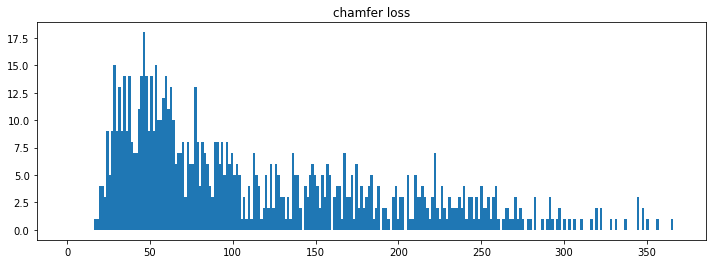

In [38]:
dists = chamfer_evaluate(predictions_list, cloud_list, id_list, cat, blueprint,  ifcConvert_executable,
                     cloudCompare_executable, temp_dir, target_dir, sample_size, threshold, icp_correction = False)
# if inference:
#     with open(model_path + 'preds_' + cat + '.pkl', 'wb') as f:
#         pickle.dump([predictions_list, id_list, dists], f)
    
plot_error_graph(dists, "chamfer loss")

In [62]:
# scaling up and down is required for icp calculations
def _visualise_predictions(predictions_list, cloud_list, id_list, cat, blueprint,  ifcConvert_executable,
                     cloudCompare_executable, temp_dir, target_dir, sample_size,
                     threshold, icp_correction = False):

    preds_list, pcd_list = [], []
    viewer_list, ifc_list = [], []
    error_count = 0

    # get predictions and pcds
    #for i in tqdm(range(len(predictions_list))):
    for i in tqdm(range(20)):
        pcd_id = id_list[i].item()
        pcd, preds = cloud_list[i].transpose(1, 0).tolist(), copy.deepcopy(predictions_list[i])
        #print(preds, inputs_list[i])

        preds = scale_preds(preds.tolist(), cat)
        print(preds)
        #pcd, preds = prepare_visualisation(pcd_id, cat, i, cloud_list, inputs_list, ext)

#         try:
        if  icp_correction:
            # note: preds are updated in place during ICP
            viewer, ifc = icp_finetuning(o3d.utility.Vector3dVector(pcd), pcd_id, cat, preds, blueprint, temp_dir, target_dir, 
                                 ifcConvert_executable, cloudCompare_executable, sample_size, threshold, True)
        else:
            #print(preds)
            viewer, ifc = visualize_predictions([pcd], cat, [preds], blueprint, visualize=True)


        preds_list.append(preds)
        pcd_list.append(pcd)
        viewer_list.append(viewer)
        ifc_list.append(ifc)

#         except Exception as e:
#             print("ICP error", pcd_id, e)
#             error_count += 1


    print("error_count", error_count)    
    return viewer_list

In [63]:
viewers = _visualise_predictions(predictions_list, cloud_list, id_list, cat, blueprint,  ifcConvert_executable,
                     cloudCompare_executable, temp_dir, target_dir, sample_size, threshold, icp_correction = False)

  0%|          | 0/20 [00:00<?, ?it/s]

[404.64770793914795, 1268.538236618042, 321.3639557361603, 723.7441539764404, 0.058742865920066833, -0.053719498217105865, 0.14230217039585114, -0.15611180663108826, 0.8816319704055786, 0.05143629387021065, 0.9260274171829224, 0.6388445496559143, 0.6916926503181458, -0.56488436460495, 0.7896255850791931, 0.016496621072292328, 0.9073066115379333, 0.13381005823612213, 0.8201855421066284]
[345.72938084602356, 1567.918300628662, 301.9225001335144, 730.3755283355713, 0.039540812373161316, -0.08097883313894272, 0.01993338018655777, -0.041515275835990906, 0.9807680249214172, -0.5307862162590027, 0.5109050869941711, 0.060004740953445435, 1.0100102424621582, 0.03552084043622017, 0.9739677906036377, 0.002033319789916277, 1.0017802715301514, -0.7921959161758423, 0.5412901639938354]
[237.07446455955505, 1678.7033081054688, 202.10114121437073, 838.3263349533081, -0.03282646834850311, -0.021662015467882156, 0.16493424773216248, 0.41590601205825806, 0.7538986802101135, -0.35496944189071655, 0.7456005

In [65]:
for v in viewers:
    print(v)

In [ ]:
# icp_correction = False
# viewers, ifcs = [], []
# preds_list, pcd_list = [], []

# for i in range(1,4):
#     pcd_id = id_list[i].item()
#     #print(pcd_id) 
        
#     #print("p", predictions_list[i], "in", inputs_list[i])

# #     #pcd, preds = prepare_visualisation(pcd_id, cat, i, cloud_list, predictions_list, path, ext)
# #     pcd, preds = cloud_list[i].transpose(1, 0), copy.deepcopy(predictions_list[i])
# #     print(pcd.shape)
# #     preds = scale_preds(preds.tolist(), cat)
# # #     pcd2, input_preds = prepare_visualisation(pcd_id, cat, i, cloud_list, inputs_list, path, ext)
# # #     indices_to_replace = [5, 6, 7]
# # #     for i in indices_to_replace:
# # #         preds[i] = input_preds[i]
    
# #     #try:
# #     if not icp_correction:
# #         viewer, ifc = visualize_predictions([pcd], cat, [preds], blueprint, visualize=True)

# #     else:
# #         viewer, ifc = icp_finetuning(pcd, pcd_id, cat, preds, blueprint, temp_dir, target_dir, 
# #                              ifcConvert_executable, cloudCompare_executable, sample_size, threshold)

# #     viewers.append(viewer) 
# #     ifcs.append(ifc)
# #     preds_list.append(preds)
# #     pcd_list.append(pcd)
       
# # #     except Exception as e:
# # #         print("ICP error", pcd_id, e)
        
#     preds_list.append(inputs_list[i])
#     pcd_list.append(cloud_list[i].transpose(1, 0))

# cloud = o3d.geometry.PointCloud()
# chamfer_dists = []
# for i, preds in enumerate(preds_list):
#     pcd = pcd_list[i]
#     chamfer_distance, cl = get_chamfer_dist_single(pcd, preds, cat)
#     chamfer_dists.append(chamfer_distance)
    
# print("chamfer_distance", sum(chamfer_dists)/len(chamfer_dists))
# print("chamfer_distance", chamfer_dists)
# cloud.points = o3d.utility.Vector3dVector(np.array(cl))
# o3d.io.write_point_cloud("generated.pcd", cloud)
# cloud.points = o3d.utility.Vector3dVector(pcd)
# o3d.io.write_point_cloud("pcd.pcd", cloud)


# #tensor based chamfer dist
# preds_tensor = torch.tensor(preds_list).cuda()
# pcd_tensor = torch.transpose(torch.tensor(pcd_list).cuda().float(), 1,2)
# #print(pcd_tensor.shape)
# chamfer_distance = get_chamfer_loss_tensor(preds_tensor, pcd_tensor)
# print("chamfer", chamfer_distance)


# # for i, cl in enumerate(clouds_tensor.detach().cpu().numpy()):
# #     cloud.points = o3d.utility.Vector3dVector(cl)
# #     o3d.io.write_point_cloud("axis_"+str(i)+".pcd", cloud)
# #     cloud.points = pcd_list[i]
# #     o3d.io.write_point_cloud("pcd_"+str(i)+".pcd", cloud)
    
# # cloud = generate_elbow_cloud(preds)
    
# #chamfer_distance = get_chamfer_dist_single(cloud, pcd)
# #print("chamfer_distance", chamfer_distance)




In [ ]:
plot_parameter_errors(inputs_list, predictions_list, cat)

#### BP data Visualisation

In [14]:
batch_visualise(model_path, blueprint, path, ext, device, ifc=False)

tee 873
elbow 8438
[Open3D WARNING] Read PCD failed: unable to open file: tee_fix/elbow/test/5199.pcd


/home/haritha/miniconda3/envs/cdbb/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
#merge_clouds(path, 'pipe')

### Misc

In [ ]:
# PCA
#testset_PCA(cloud_list, inputs_list, testDataLoader, cat)

In [ ]:
print(torch. __version__)

In [ ]:
# preds = inputs_list[:512]
# #preds = scale_preds(preds, cat, up=0)
# pcd = cloud_list[1].transpose(1, 0)
# print(preds)

# preds_tensor = torch.tensor(np.array(preds)).cuda().float()
# gen_cloud = generate_tee_cloud_tensor(preds_tensor)
# print(gen_cloud.shape)
# #gen_cloud = generate_pipe_cloud(preds)

# points = gen_cloud.detach().cpu().numpy()
# #points = np.array(gen_cloud)
# cloud = o3d.geometry.PointCloud()
# print(type(points), points.shape)
# cloud.points = o3d.utility.Vector3dVector(points[0])
# #cloud.points = o3d.utility.Vector3dVector(points)
# o3d.io.write_point_cloud("pipe_gen.pcd", cloud)

# cloud.points = o3d.utility.Vector3dVector(pcd)
# o3d.io.write_point_cloud("pipe_input.pcd", cloud)

In [ ]:
# chamfer loss
#v, loss = chamfer_fine_tune(50, 0.0001, predictions_list[0], cloud_list[0], cat, blueprint)

In [10]:
#imit = 50
limit = len(predictions_list)

#v, modified_preds = chamfer_fine_tune(100, 0.01, predictions_list[:limit], cloud_list[:limit], cat, blueprint, alpha=3, visualise=True)
modified_preds = chamfer_fine_tune(100, 0.01, predictions_list[:limit], cloud_list[:limit], cat, blueprint, alpha=3, visualise=False)


/home/haritha/documents/industrial-facility-relationships/src/finetune.py:55: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  preds_t = torch.tensor(preds, requires_grad=True, device=cuda)


intial loss tensor([ 72.7457, 285.3601,  91.1770, 229.5777,  26.7113,  54.5800,  72.9304,
        229.7910, 261.9828, 219.5352,  47.5388, 178.9522,  54.6421,  64.9285,
         40.4096,  27.9463,  60.7795,  33.5723,  32.7785, 166.6932,  45.6096,
         48.8996, 193.3366,  48.8056, 369.1729, 153.0797, 101.0171, 152.3039,
         50.2219,  29.4532,  48.8366, 206.5753,  42.9186, 210.0446, 344.2191,
         78.4833,  53.2858, 184.7378,  49.0704,  27.7535, 211.6326, 140.3829,
         77.6469, 135.4090,  69.8411, 183.0575, 345.2131, 327.9049,  77.4715,
        211.2093, 288.6176, 222.7681, 126.3871, 172.8012,  65.1585, 146.1870,
         58.8506, 328.9963,  19.5966,  34.1905,  46.5577,  73.9320, 153.6878,
         25.4832, 114.6561, 283.5219, 233.3473, 116.6568, 155.5612,  46.2783,
         28.1922,  26.1088, 177.3545,  72.1232,  62.6319,  30.8497, 156.9270,
        118.9725,  52.0671, 217.9892,  58.2799,  61.9297, 284.7921, 274.5149,
        217.3253,  39.1457, 161.6779,  50.7496, 166.

  0%|          | 0/100 [00:00<?, ?it/s]

0 loss 280.4175
1 loss 250.20285
2 loss 224.82056
3 loss 203.34135
4 loss 184.84064
5 loss 168.76752
6 loss 154.78462
7 loss 142.60893
8 loss 132.05493
9 loss 122.857376
10 loss 114.896164
11 loss 108.05939
12 loss 102.176926
13 loss 97.13708
14 loss 92.85265
15 loss 89.236496
16 loss 86.13509
17 loss 83.45091
18 loss 81.09401
19 loss 79.028854
20 loss 77.19163
21 loss 75.51023
22 loss 73.925934
23 loss 72.40219
24 loss 70.89303
25 loss 69.380325
26 loss 67.87675
27 loss 66.400635
28 loss 64.9159
29 loss 63.439472
30 loss 61.997314
31 loss 60.570946
32 loss 59.21238
33 loss 57.882507
34 loss 56.595455
35 loss 55.39809
36 loss 54.262234
37 loss 53.17237
38 loss 52.12706
39 loss 51.168327
40 loss 50.2687
41 loss 49.451458
42 loss 48.64978
43 loss 47.860336
44 loss 47.11779
45 loss 46.448105
46 loss 45.802803
47 loss 45.186844
48 loss 44.61208
49 loss 44.053215
50 loss 43.523422
51 loss 43.053715
52 loss 42.562588
53 loss 42.110214
54 loss 41.71486
55 loss 41.32937
56 loss 40.9305
57 loss

In [10]:
print(v)

/home/haritha/miniconda3/envs/cdbb/lib/python3.9/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


[, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ]


In [ ]:
plot_parameter_errors(inputs_list, modified_preds, cat)

  0%|          | 0/873 [00:00<?, ?it/s]

error_count 0
avg 25.845222 8 81.23336 5.7887554 [0.00363361 0.00361522 0.00347934 0.00333888 0.00332844 0.00330281
 0.00327029 0.00320208 0.00308111 0.00305188 0.003017   0.00300097
 0.00298635 0.00298453 0.00296108 0.00293984 0.0028427  0.00273377
 0.00271035 0.00257294 0.00257053 0.00251534 0.00248736 0.00246221
 0.00245024 0.00244671 0.00243484 0.00239307 0.00235563 0.00233351
 0.00227989 0.00225692 0.0022544  0.00223377 0.00218718 0.00218546
 0.00216148 0.00215503 0.00214465 0.00212931 0.00211425 0.00211008
 0.00209362 0.00204749 0.00203541 0.00202759 0.00201302 0.00201134
 0.00200666 0.00199234 0.00198805 0.00197542 0.00196526 0.00195369
 0.00195254 0.00194289 0.00194161 0.00193325 0.00192939 0.0019288
 0.00192135 0.00190369 0.00188339 0.00188056 0.00187678 0.00186132
 0.00184503 0.00184322 0.00184135 0.00183442 0.00183383 0.00183125
 0.00182574 0.00182355 0.00181633 0.00179543 0.00179485 0.00179379
 0.00177864 0.00177864 0.00176874 0.00176727 0.00176214 0.00175945
 0.00175816 0.

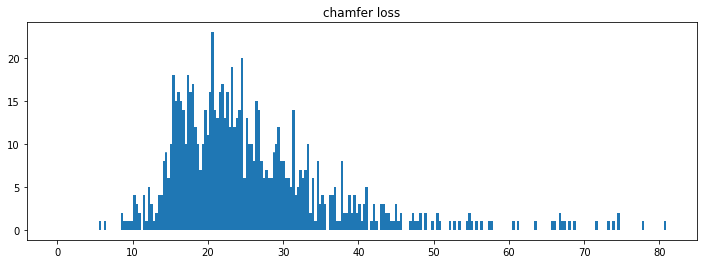

In [13]:
dists = chamfer_evaluate(modified_preds, cloud_list[:limit], id_list, cat, blueprint,  ifcConvert_executable,
                     cloudCompare_executable, temp_dir, target_dir, sample_size, threshold, icp_correction = False)

if inference:
    with open(model_path/('preds_finetuned_' + cat + '.pkl'), 'wb') as f:
        pickle.dump([modified_preds, id_list, dists], f)

plot_error_graph(dists, "chamfer loss")

In [ ]:

# generate points on surface of tee
def generate_tee_cloud(preds):
    # read params
    r1, l1, r2, l2 = abs(preds[0]), preds[1], preds[2], preds[3]
    d1 = get_direction_from_trig(preds, 7)
    d2 = get_direction_from_trig(preds, 13)
    p2 = [preds[4], preds[5], preds[6]]
    p1 = [p2[i] - ((l1*d1[i])/2) for i in range(3)]

    # get new coordinate frame of tee
    old_z = (0., 0., 1.)
    x_axis = vector_normalise(np.cross(d1, old_z))
    y_axis = vector_normalise(np.cross(d1, x_axis))

    # sample points on main tube
    no_of_axis_points = 50    
    no_of_ring_points = 40
    tube1_points = get_cylinder_points(no_of_axis_points, no_of_ring_points, 
                                      r1, l1, p1, d1, x_axis, y_axis)

    # sample points on secondary tube
    x_axis = vector_normalise(np.cross(d2, old_z))
    y_axis = vector_normalise(np.cross(d2, x_axis))   
    tube2_points = get_cylinder_points(no_of_axis_points, no_of_ring_points, 
                                      r2, l2, p2, d2, x_axis, y_axis)

    # remove points from secondary tube in main tube
    tube2_points = np.array(tube2_points)
    p1, p2 = np.array(p1), np.array(p2)
    p2p1 = p2-p1
    p2p1_mag = vector_mag(p2p1)
    tube2_points_ref = []

    for q in tube2_points:
        dist = vector_mag(np.cross((q-p1), (p2p1))) / p2p1_mag
        print(dist, r1)
        if dist > r1:
            print('r', dist)
            tube2_points_ref.append(q.tolist())

    # remove points from main tube in secondary tube
    tube1_points = np.array(tube1_points)
    p3 = np.array(p2 + d2)
    p2p3 = p2-p3
    p2p3_mag = vector_mag(p2p3)
    tube1_points_ref = []

    for q in tube1_points:
        dist = vector_mag(np.cross((q-p3), (p2p3))) / p2p3_mag
        cos_theta = np.dot(q-p2, p2p3)
        if dist > r2 or cos_theta > 0:
            tube1_points_ref.append(q.tolist())

    # make sure not all points are deleted if predictions are very wrong
    thresh = 50
    if len(tube1_points_ref) < thresh and len(tube2_points_ref) < thresh:
        return (tube1_points + tube2_points)
    elif len(tube2_points_ref) < thresh:
        return (tube1_points_ref + tube2_points)
    elif len(tube1_points_ref) < thresh:
        return (tube1_points + tube2_points_ref)
    else:
        return (tube1_points_ref + tube2_points_ref)

In [11]:
preds = torch.tensor([predictions_list[1]]).cuda()
print(predictions_list[1])
pcd = generate_tee_cloud_tensor(preds)
#tee = generate_tee_cloud(predictions_list[0])
tee = pcd[0].cpu().numpy()
tee = o3d.utility.Vector3dVector(tee)
tee_cloud = o3d.geometry.PointCloud()
tee_cloud.points = tee
o3d.io.write_point_cloud("tee_cl.pcd", tee_cloud)


/tmp/ipykernel_1893/4259431617.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975993/work/torch/csrc/utils/tensor_new.cpp:230.)
  preds = torch.tensor([predictions_list[1]]).cuda()


[-0.17579098  1.5928817   0.170317    0.85650873 -0.03629723  0.14758301
 -0.20166188 -0.67296106  0.7596579  -0.4671862   0.8439026   0.39583406
  0.8861705   0.4789741   0.86622447 -0.03916375  0.9693682   0.6652696
  0.6601773 ]


True

In [13]:
original = cloud_list[2]
points= o3d.utility.Vector3dVector(original.transpose(1,0))
tee_cloud.points = points
o3d.io.write_point_cloud("tee_cl_inp.pcd", tee_cloud)

True

In [ ]:
# undo normalisation opf the bp tee dataset created for inference, only for comparison with the inferred tee results
tee_path = 'tee_fix/tee/test/'
metadata_file = open("tee_fix/tee/metadata.json", 'r')
metadata = json.load(metadata_file)
output_path = 'tee_fix/tee/unnormalised/'

files = os.listdir(tee_path)
new_points = []
for f in tqdm(files):
    cloud_data = metadata[f.split(".")[0]]
    points = np.array(o3d.io.read_point_cloud(tee_path + f).points)
    print("a", points[0])
    print(cloud_data["norm_factor"], cloud_data["mean"])
    points *= cloud_data["norm_factor"]
    print("b", points[0])

    for i, pnt in enumerate(points):
        pnt += cloud_data["mean"]
    print("c", points[10])
    new_points.append(points)
        
new_points = o3d.utility.Vector3dVector(np.concatenate(new_points))
new_cloud = o3d.geometry.PointCloud()
new_cloud.points = new_points
o3d.io.write_point_cloud(output_path+"tee_bp_unnormalised.pcd", new_cloud)

## Mesh deformation